## # ECE 9039 Final Project - MULTI-CLASS MUSIC GENRE CLASSIFICATION
### Contributors:
- Chukwuemeka Momodu
- Damilola Awotunde

In [1]:
# import dependencies
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read dataset into pandas dataframe
data = pd.read_csv('./data/data.csv')
# save copy of data
original_data_copy = data.copy()

In [3]:
# print data shape
print("Dataset shape is: {0}".format(data.shape))

Dataset shape is: (17996, 17)


In [4]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
# view top 5 rows of dataset
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


## Exploratory Data Analysis (EDA)

In [6]:
# Find all categorical columns with the condition if less than 50 unique value excluding object columns (artist name and track name)
categorical_cols_dict = {}
non_cat_cols_list = []
for column in data.select_dtypes(exclude=["object"]).columns:
    num_unique_values = len(data[column].unique())
    if num_unique_values < 50:
        categorical_cols_dict[column] = num_unique_values
    else: non_cat_cols_list.append(column)

print("Categorical columns and number of categories")
print(categorical_cols_dict)

Categorical columns and number of categories
{'key': 12, 'mode': 2, 'time_signature': 4, 'Class': 11}


                                Visualising Categorical Columns:                                


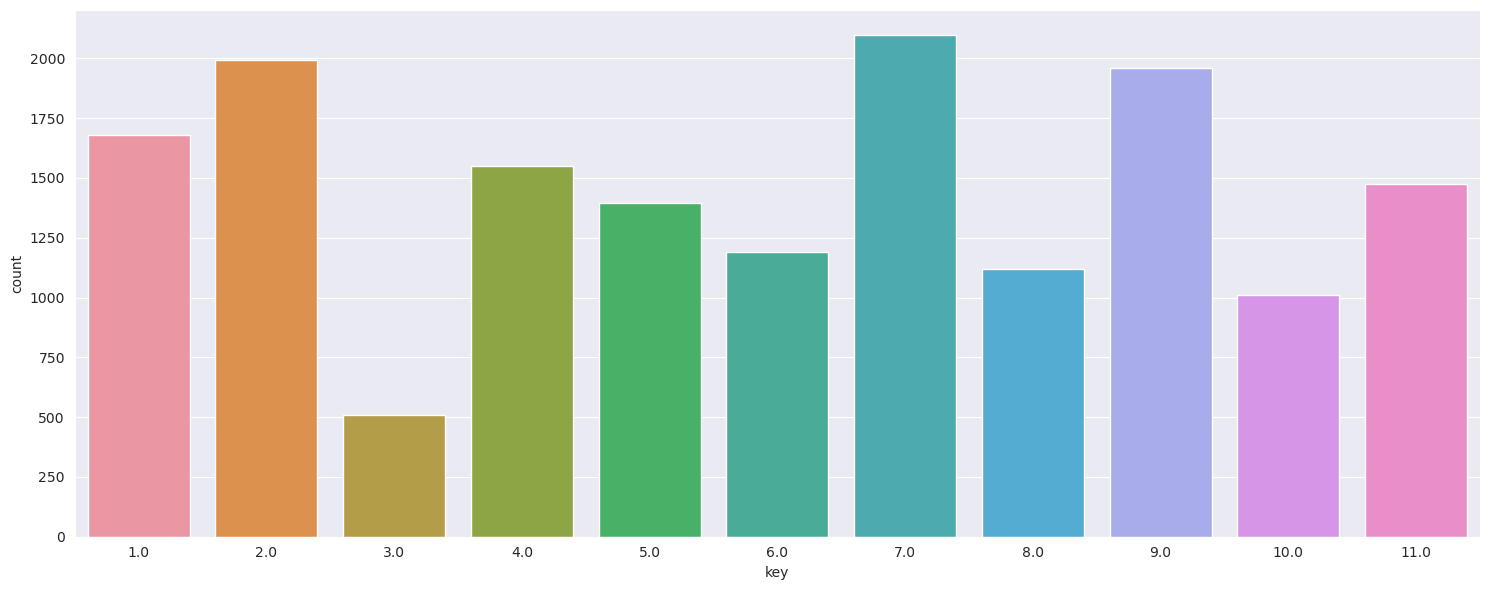

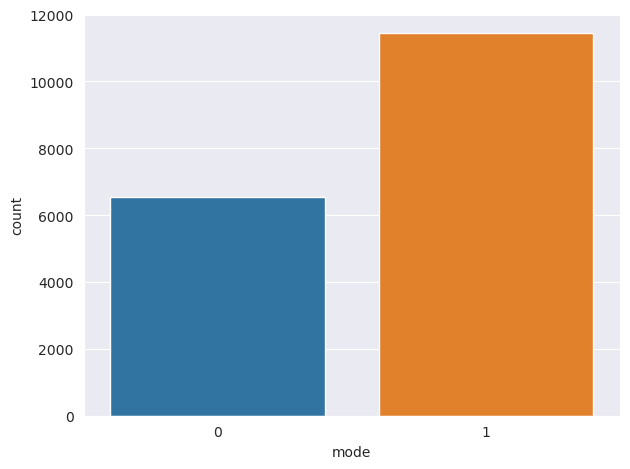

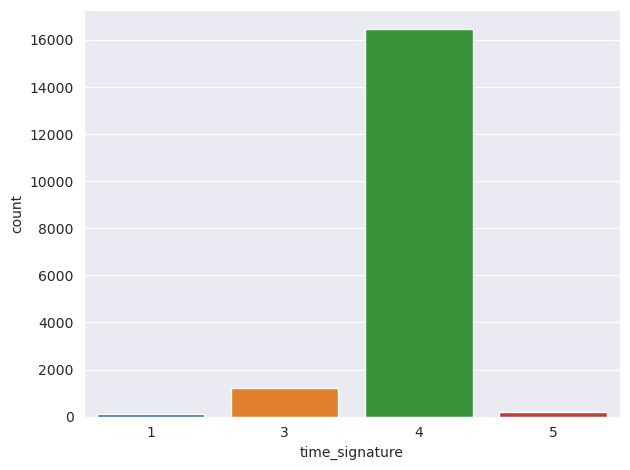

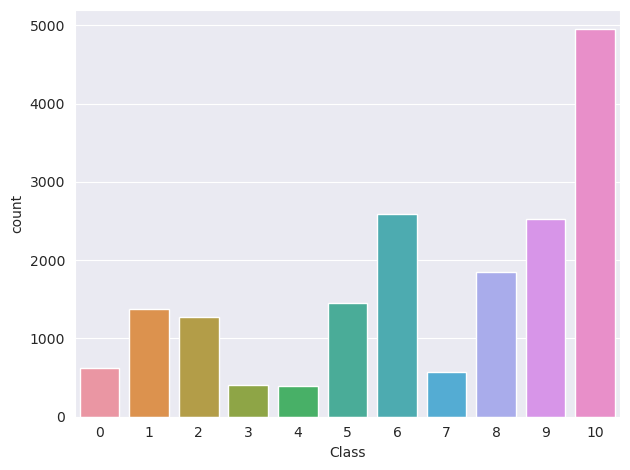

In [7]:
#Visualising the categorical Columns
print('\033[1mVisualising Categorical Columns:'.center(100))

n=3
cf = [key for key in categorical_cols_dict]
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    sns.countplot(x=data[cf[i]])
    plt.tight_layout()
    plt.show()

                              Non-Categorical Columns Distribution                              


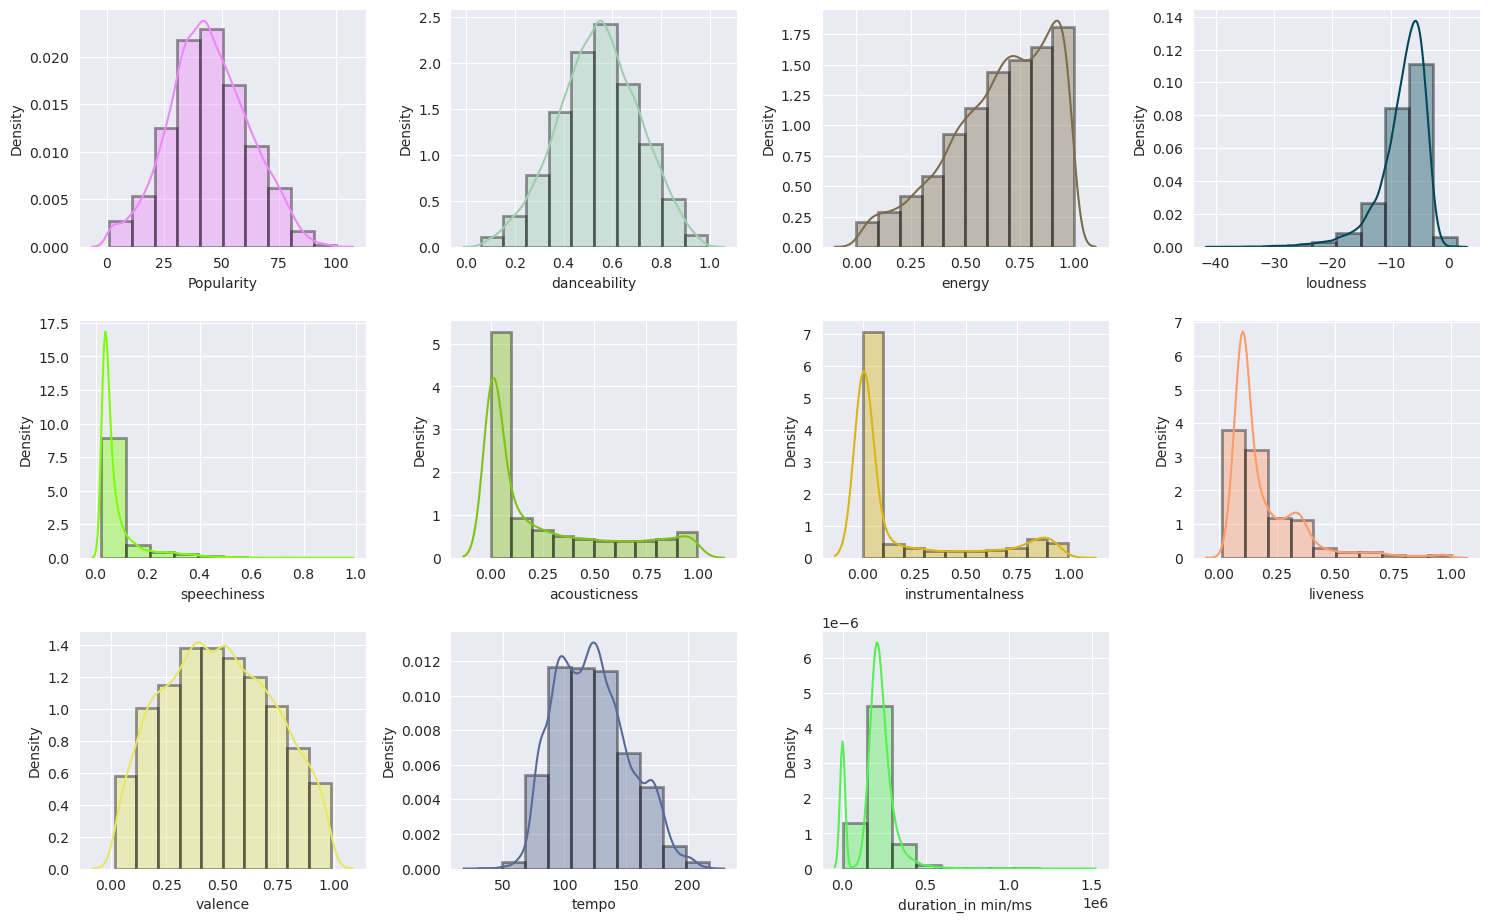

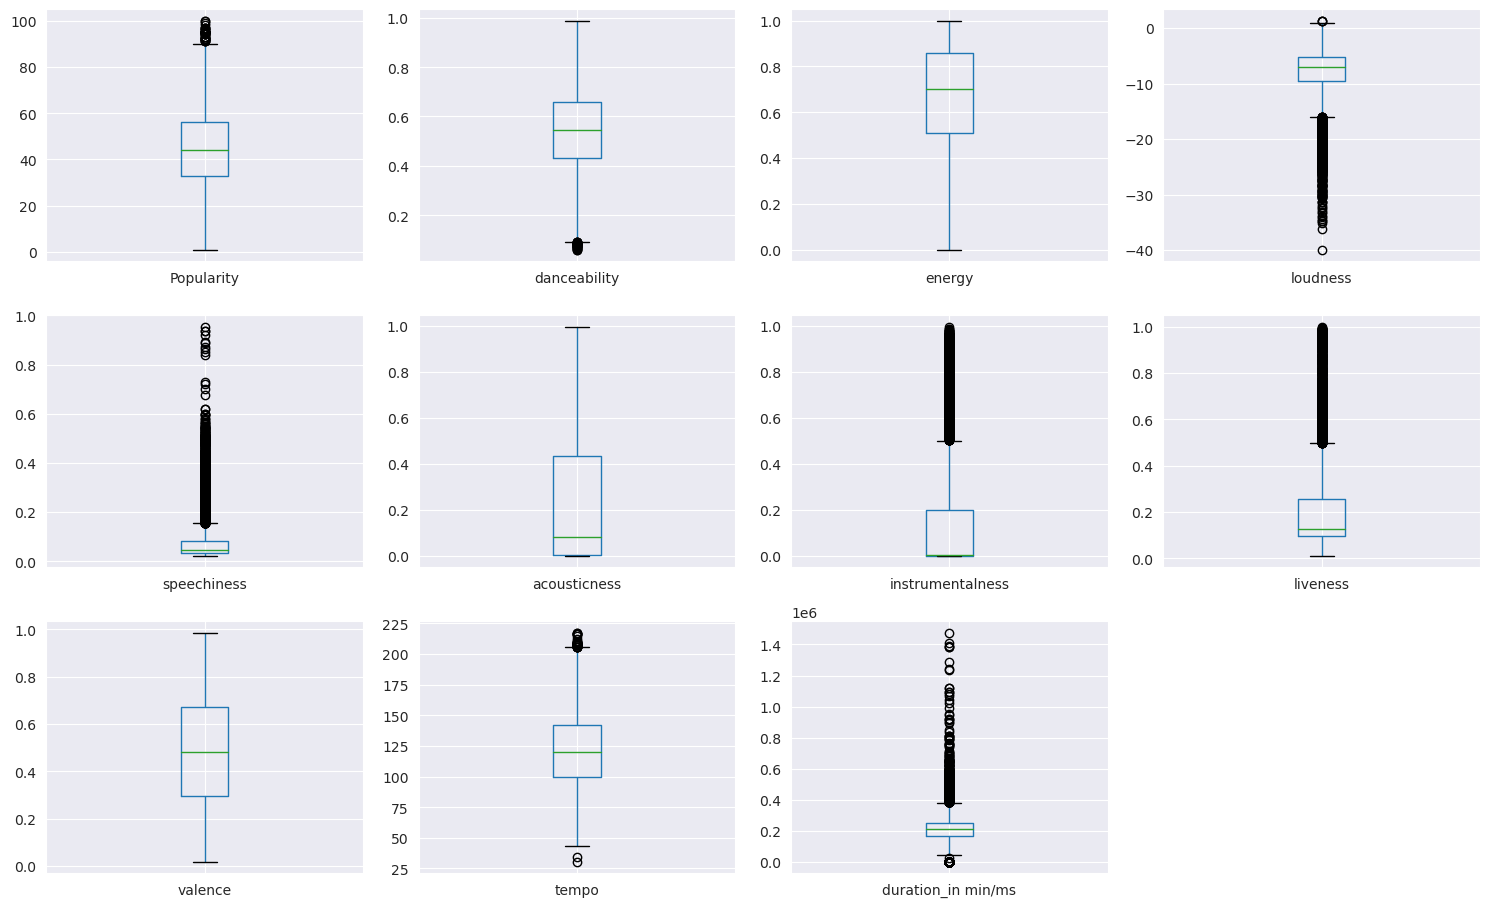

In [8]:
# Visualising the non-categorical columns

print('\033[1mNon-Categorical Columns Distribution'.center(100))

nf = non_cat_cols_list
n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(data[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    data.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers. This would be fixed in the pre-processing step

                                       Correlation Matrix                                       


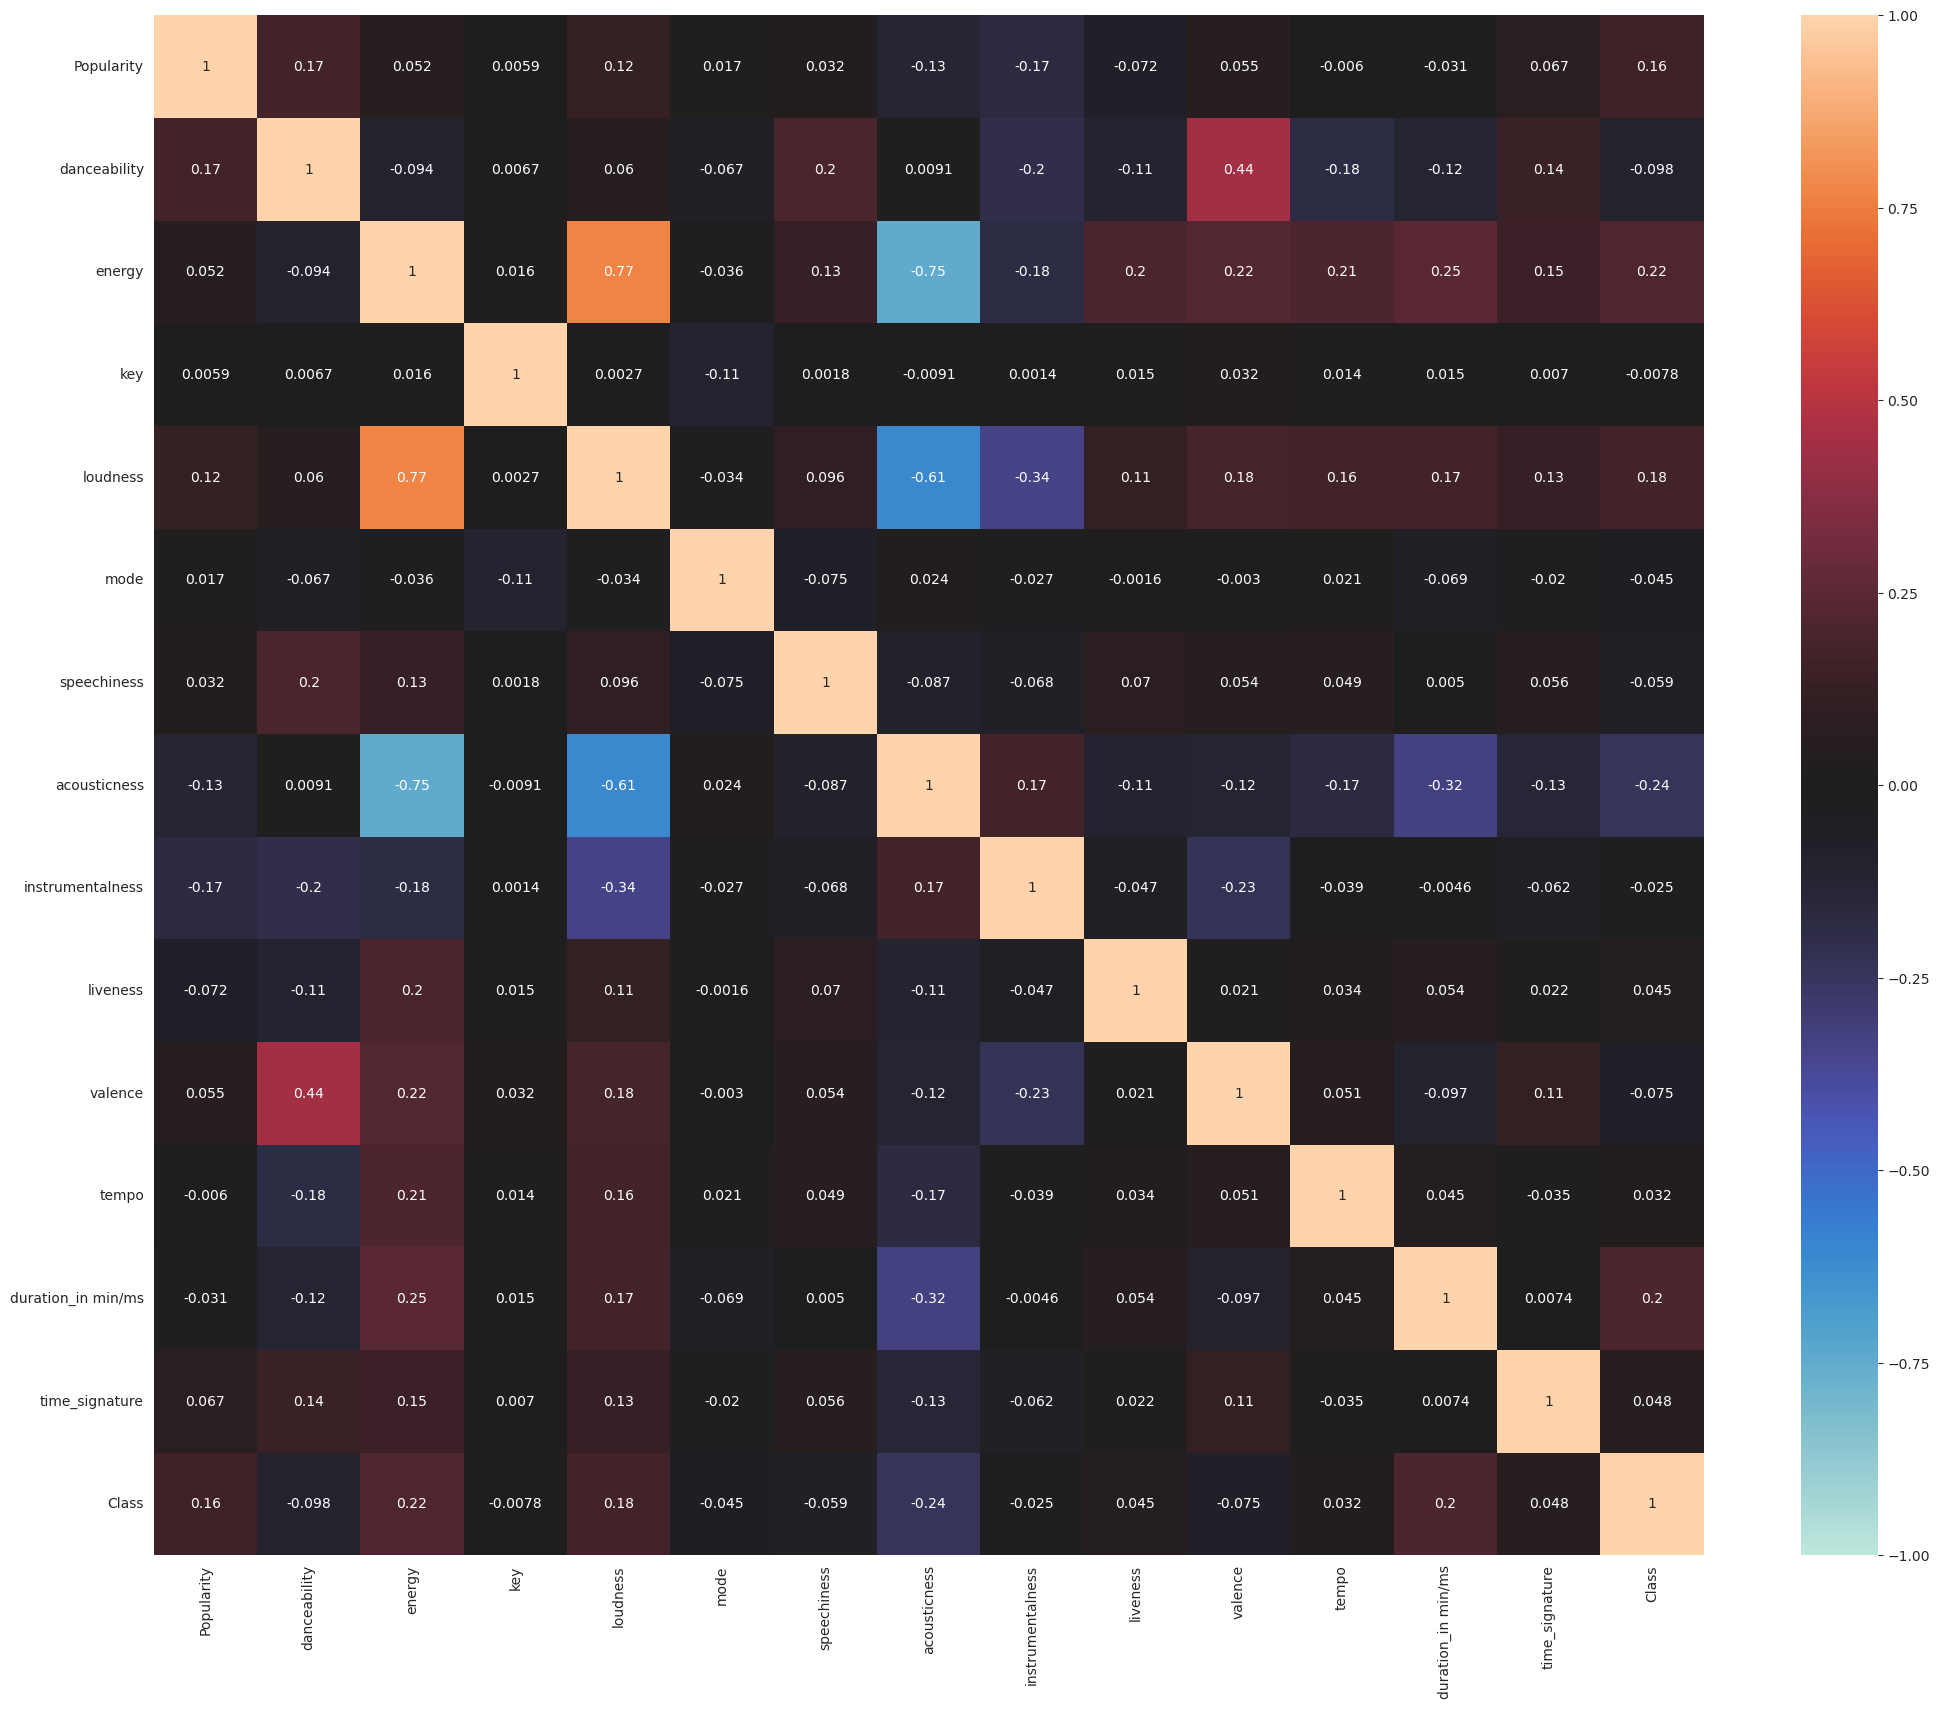

In [9]:
# Checking the correlation
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(data.select_dtypes(exclude=["object"]).corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Inference: There seems to be some high multi-correlation between the features. Skipping these for now, as the advanced ML Algorithms take care of multicollinearity.

## Data Pre-processing

In [10]:
# Show count and percentage of null values in columns
print("Columns null value count and percentage\n")
nvc = pd.DataFrame(data.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/data.shape[0],3)*100
print(nvc)

Columns null value count and percentage

                    Total Null Values  Percentage
Artist Name                         0         0.0
duration_in min/ms                  0         0.0
tempo                               0         0.0
valence                             0         0.0
liveness                            0         0.0
acousticness                        0         0.0
time_signature                      0         0.0
speechiness                         0         0.0
loudness                            0         0.0
energy                              0         0.0
danceability                        0         0.0
Track Name                          0         0.0
mode                                0         0.0
Class                               0         0.0
Popularity                        428         2.4
key                              2014        11.2
instrumentalness                 4377        24.3


In [11]:
# handling missing values

# "Popularity" column is non-categorical and has 2% null values which is relatively small
# hence replacing null values with the mean
# Create a SimpleImputer object
mean_imputer = SimpleImputer(strategy="mean")
data['Popularity'] = mean_imputer.fit_transform(data[['Popularity']])

In [12]:
# "key" column is categorical and has 11% null values which is relatively small
# hence replacing null values with the mode

mode_imputer = SimpleImputer(strategy="most_frequent")
data['key'] = mode_imputer.fit_transform(data[['key']])

In [13]:
#"instrumentalness" column has relatively substantial amount of missing values (24%)
# hence using KNN to predict missing values

# Create a KNN imputer object with k=5
knn_imputer = KNNImputer(n_neighbors=5)

# Replace null values in "instrumentalness" column with KNN imputation
columns_to_impute = ["instrumentalness"]
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])

In [14]:
# confirm all missing values have been handled
data.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

In [15]:
# Removal of any Duplicate rows (if any)
data_copy_duplicates = data.copy()
counter = 0
rs,cs = data_copy_duplicates.shape

data.drop_duplicates(inplace=True)

if data.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-data.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [16]:
# Removal of outlier:

data_copy_outliers = data.copy()

# The code calculates the first and third quartiles (Q1 and Q3) and the interquartile range (IQR) using the quantile() method.
# The IQR is then used to identify the outliers: any data point whose value is above Q3 + 1.5*IQR or below Q1 - 1.5*IQR is considered an outlier.
for i in data.select_dtypes(exclude=["object"]).columns:
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    data = data[data[i] <= (Q3+(1.5*IQR))]
    data = data[data[i] >= (Q1-(1.5*IQR))]
    data = data.reset_index(drop=True)

print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(data_copy_outliers.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(data.shape[0]))


Inference:
Before removal of outliers, The dataset had 17996 samples.
After removal of outliers, The dataset now has 9733 samples.


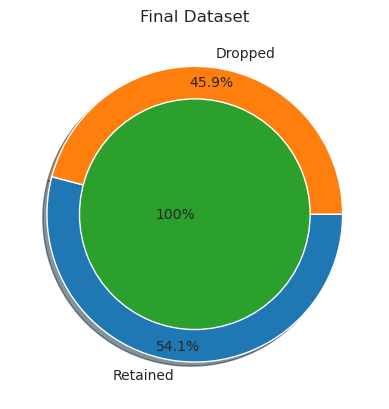


Observation: After the cleanup process, 8263 samples were dropped, while retaining 54.08% of the data.


In [22]:
# Final Dataset size after performing Preprocessing

plt.title('Final Dataset')
plt.pie([data.shape[0], original_data_copy.shape[0]-data.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([data.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mObservation:\033[0m After the cleanup process, {original_data_copy.shape[0]-data.shape[0]} samples were dropped, \
while retaining {round((data.shape[0]*100/(original_data_copy.shape[0])),2)}% of the data.')

## Feature Selection and Engineering